# Imports and Settings

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import  StandardScaler
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV


from sklearn.metrics import * 

import matplotlib.pyplot as plt
import warnings

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20.0, 5)
warnings.filterwarnings('ignore')

# Preproccesing Data For Algorithms
### Choosing Features:
From the `Exploratory Data Analysis`, it was discovered that most of the trends in the data with respect to flight arrival delays had to do with the amount of traffic occuring during the time of the particular flight. 
- Apart from that the `hour` of the flight had information on the chances of a delay that wasn't completely congruent with the amount of traffic.

Appropriately, the features I have decided to use for the algorithms are time based. Since the time of a flight should be an excellent indicator of how much relative traffic one can expect, for a given period.

### Features:
Data:
- Month
- Week
- Day
- Day of Week
- Hour

Target:
- Whether the flight delay is greater than 0
  - 1 (True) would indicate a delayed flight
  - 0 (False) would indicate a flight that was on time or early

### Evaluation:
1. Algorithm Spotchecking
    - several classification algorithms will be tested, with `cross validation`
    
2. Evaluation: 
  - The cross validation will occur across several common metrics
  - However the metic of `focus` will be `Recall` because False Negative are more expensive in the case of predicting flight delays


In [3]:
df = pd.read_csv('flights_sample.csv', sep=';')

In [4]:
df = df[['fl_date', 'crs_dep_time', 'arr_delay']].copy(deep=True)

In [5]:
df['fl_date'] = pd.to_datetime(df['fl_date'], format='%Y-%m-%d')
df['month'] =  df.fl_date.dt.month
df['week'] = df.fl_date.dt.isocalendar().week
df['day'] = df.fl_date.dt.dayofyear
df['day_of_week'] = df.fl_date.dt.dayofweek
df['hour'] = pd.cut(df['crs_dep_time'], bins=24)
df['delay_bool'] = df['arr_delay'] > 0

In [6]:
lb = LabelBinarizer()
df['delay_bool'] = lb.fit_transform(df['delay_bool'].values) 

In [7]:
df

,fl_date,crs_dep_time,arr_delay,month,week,day,day_of_week,hour,delay_bool
0,2019-05-22,1140,22.0,5,21,142,2,"(1081.75, 1180.0]",1
1,2018-08-28,800,-5.0,8,35,240,1,"(787.0, 885.25]",0
2,2018-01-14,1447,5.0,1,2,14,6,"(1376.5, 1474.75]",1
3,2018-02-20,1440,-20.0,2,8,51,1,"(1376.5, 1474.75]",0
4,2019-06-07,1150,-7.0,6,23,158,4,"(1081.75, 1180.0]",0
...,...,...,...,...,...,...,...,...,...
99991,2018-07-24,1300,NaN,7,30,205,1,"(1278.25, 1376.5]",0
99992,2019-02-04,1430,71.0,2,6,35,0,"(1376.5, 1474.75]",1
99993,2019-11-21,1510,56.0,11,47,325,3,"(1474.75, 1573.0]",1
99994,2018-10-16,1035,0.0,10,42,289,1,"(983.5, 1081.75]",0


In [8]:
df.delay_bool.value_counts()

0    65335
1    34661
Name: delay_bool, dtype: int64

In [9]:
X = df[['month', 'week', 'day', 'day_of_week', 'hour']].copy(deep=True)

le = LabelEncoder()
X['hour'] = le.fit_transform(X['hour'].astype(str))

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
y = df['delay_bool']

In [11]:
 X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
y_test.value_counts()

0    16397
1     8602
Name: delay_bool, dtype: int64

In [13]:
def cv_plot(model):
  """
  Runs a 5 fold cross validation on a model, and plots a bar graph for 
  the metrics {recalll, accuracy, precision, f1} representing each folds
  outcome.

  Takes [model] ad an input: Which is the cclassification algorithm
  that has already been instantiated. 
  """
  model_cv = cross_validate(model, X_train, y_train, cv=5, verbose=0, scoring=['recall', 'accuracy', 'precision','f1'])
  
  display(pd.DataFrame(model_cv).drop(columns=['fit_time', 'score_time']))
  pd.DataFrame(model_cv).drop(columns=['fit_time', 'score_time']).plot.bar()
  plt.title(str(model))
  return None

# Systematic Search For Best Classification Algorithm
1. Linear Models:
  - Logistic Regression
  - Naive Bayes
2. Non-Linear Models:
  - Support Vector Machines
3. Tree Based Models:
  - Random Forest Classifier
  - XGBoost

## Logistic Regression

In [14]:
lg = LogisticRegression()

In [15]:
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79     16397
           1       0.67      0.00      0.00      8602

    accuracy                           0.66     24999
   macro avg       0.66      0.50      0.40     24999
weighted avg       0.66      0.66      0.52     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.000384,0.652267,0.25,0.000766
1,0.000384,0.652267,0.25,0.000766
2,0.000000,0.652310,0.00,0.000000
3,0.000192,0.652310,0.20,0.000383
4,0.000000,0.652510,0.00,0.000000


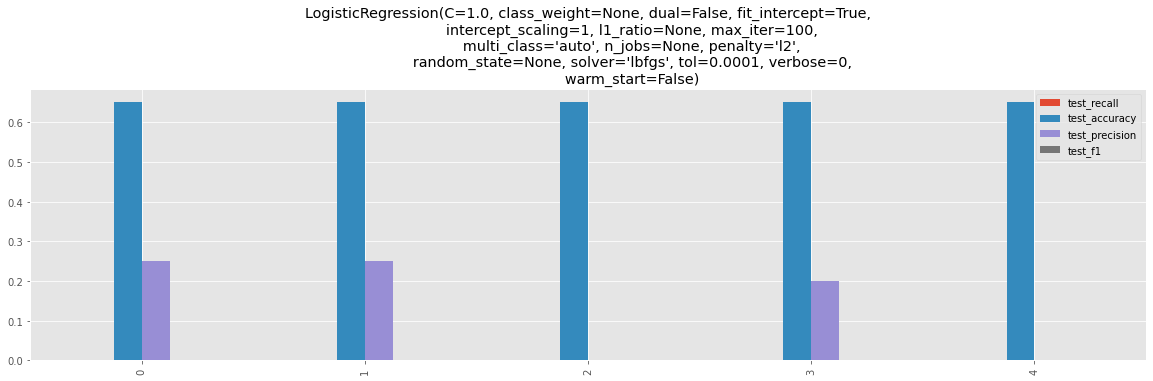

In [16]:
cv_plot(lg)

## naive bayes

In [17]:
X = df[['month', 'week', 'day', 'day_of_week', 'hour']].copy(deep=True)
X['hour'] = le.fit_transform(X['hour'].astype(str))

In [18]:
gnb  = GaussianNB()

In [19]:
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79     16397
           1       0.00      0.00      0.00      8602

    accuracy                           0.66     24999
   macro avg       0.33      0.50      0.40     24999
weighted avg       0.43      0.66      0.52     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.0,0.652533,0.0,0.0
1,0.0,0.652533,0.0,0.0
2,0.0,0.652577,0.0,0.0
3,0.0,0.652510,0.0,0.0
4,0.0,0.652510,0.0,0.0


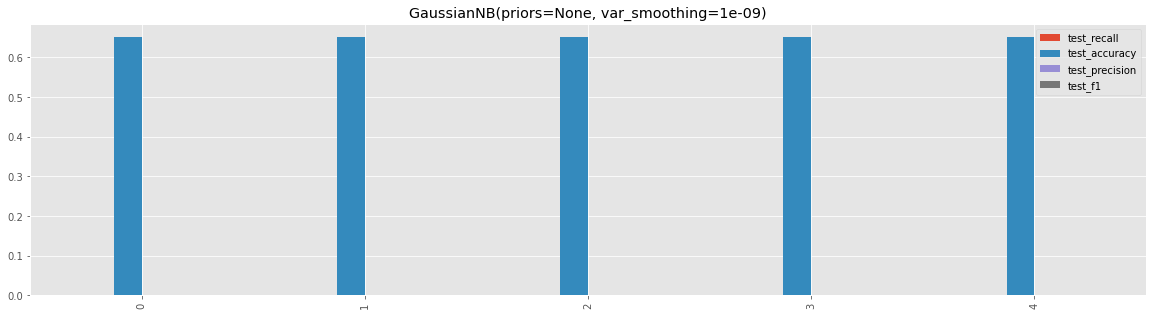

In [20]:
cv_plot(gnb)

## SVM

In [21]:
svm_clf = svm.SVC(kernel='sigmoid') # best kernel I found 

In [22]:
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66     16397
           1       0.35      0.35      0.35      8602

    accuracy                           0.55     24999
   macro avg       0.50      0.50      0.50     24999
weighted avg       0.55      0.55      0.55     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.346700,0.551733,0.352517,0.349584
1,0.345741,0.553200,0.353750,0.349699
2,0.372673,0.552504,0.360631,0.366553
3,0.366654,0.557237,0.363931,0.365287
4,0.344589,0.542636,0.342748,0.343666


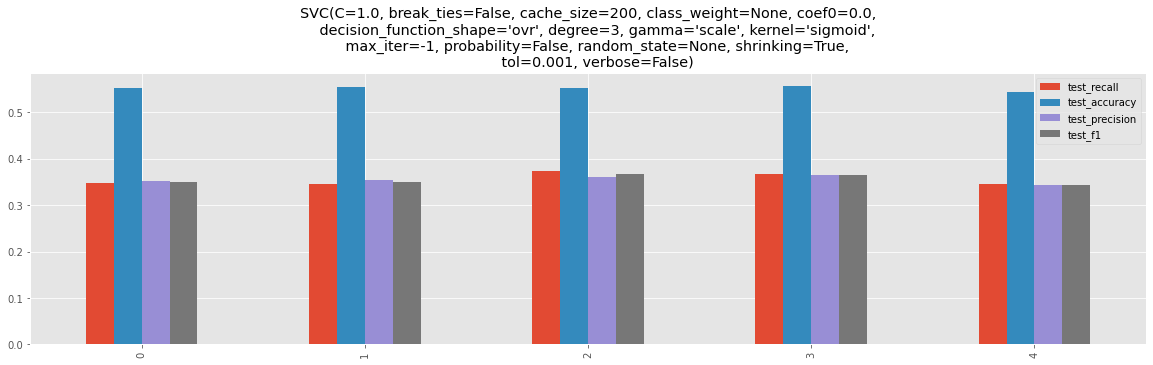

In [23]:
cv_plot(svm_clf)

## RandomForrest Classifier

In [24]:
rf = RandomForestClassifier()

In [25]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.78      0.72     16397
           1       0.41      0.29      0.34      8602

    accuracy                           0.61     24999
   macro avg       0.54      0.54      0.53     24999
weighted avg       0.58      0.61      0.59     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.301995,0.608867,0.413884,0.349196
1,0.309478,0.601400,0.403957,0.350462
2,0.303972,0.608241,0.413253,0.350287
3,0.316577,0.611107,0.420811,0.361327
4,0.322525,0.606640,0.415062,0.362989


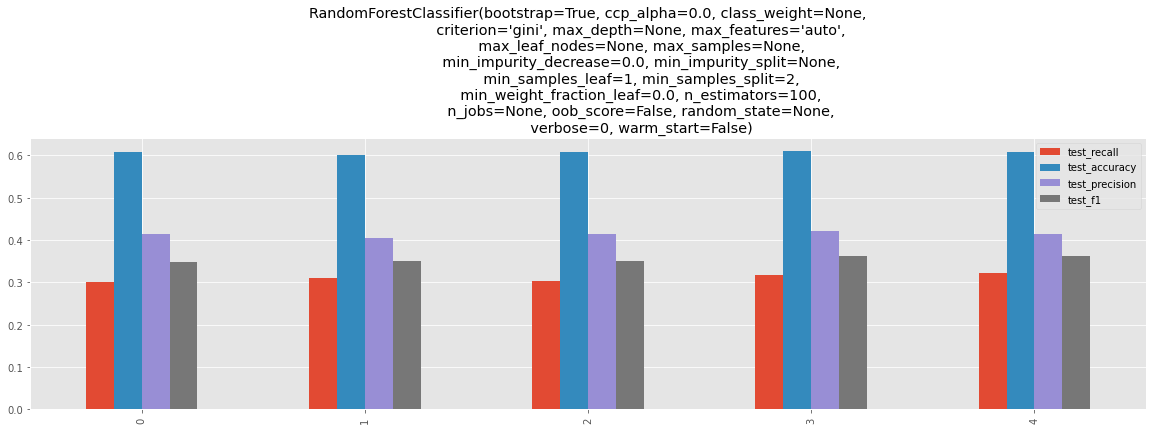

In [26]:
cv_plot(rf)

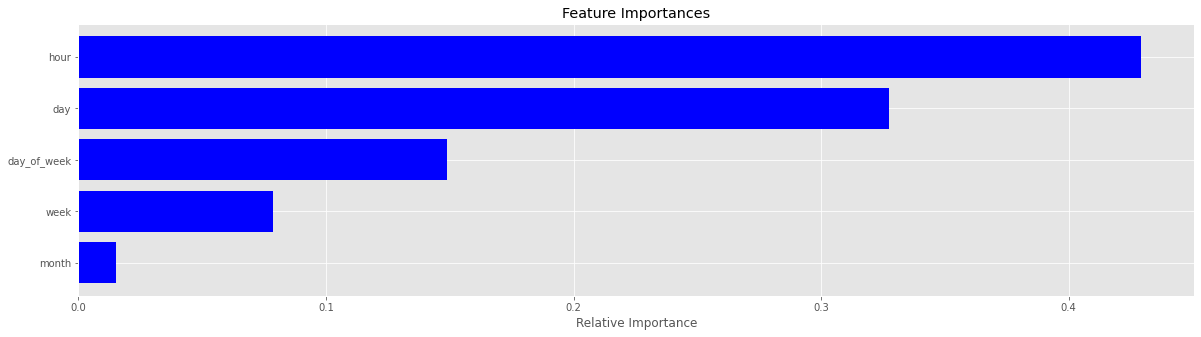

In [33]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Hour feature is the most important for the Random Forest Classifier, which support the findining in the EDA Notebook.

## XGBoost Classifier

In [28]:
xgbc = xgb.XGBClassifier()

In [29]:
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.99      0.79     16397
           1       0.53      0.01      0.02      8602

    accuracy                           0.66     24999
   macro avg       0.59      0.50      0.41     24999
weighted avg       0.61      0.66      0.53     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.020338,0.654733,0.592179,0.039325
1,0.015925,0.651533,0.458564,0.030781
2,0.018039,0.651377,0.456311,0.034706
3,0.015541,0.653777,0.566434,0.030252
4,0.014965,0.653910,0.577778,0.029175


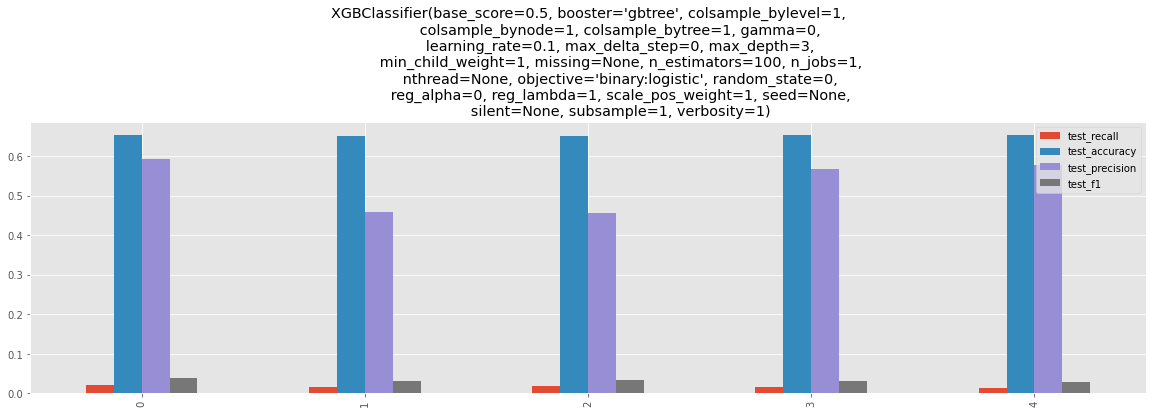

In [30]:
cv_plot(xgbc)

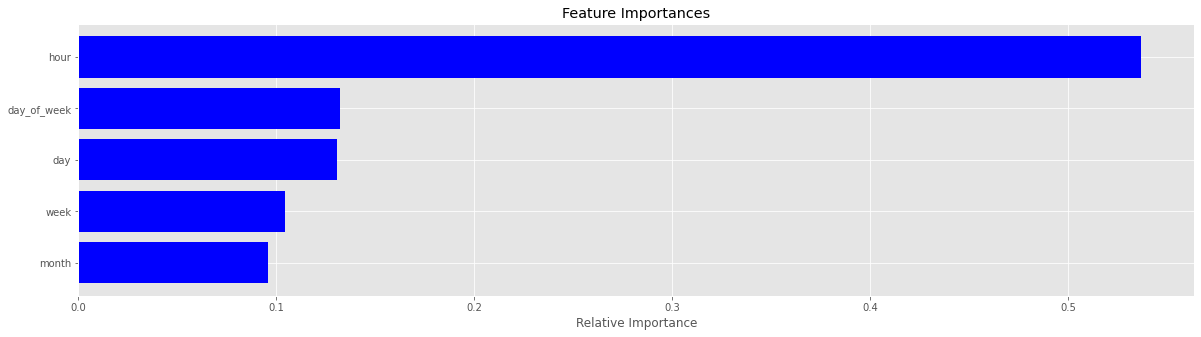

In [31]:
features = X.columns
importances = xgbc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Hour feature is the most important for the XGBoost Classifier, which support the findining in the EDA Notebook.

# Systematic search for best classification algorithm: Conclusion
All the classification algorithms had an  `accuracy` of around `0.6`
at predicting flight delays. However when looking at the `classification report` and `cross validation bar plots` it is clear that this accuracy score is a poor metric for this problem. The score is only being achieved because most of the alogrithms are predicting the most common class most of the time.

When considering the hgh cost of False Negatives in this scenario, the most important metric is `recall`

## Best Algorithms With Respect To Recall:
- Support Vector Machines
- Random Forest Classifier

These two algorithms had the best performance. Despite this, their scores are still poor. Hyper-parameter tunning may improve the scores, however this notebook will not do that, due to computing constraints.

Another possible conclusion is that not enough information was given or (deduced) to build good models. From the EDA done, the only predictive information I could find was the flight traffic, which I decided to represent by using different time-periods as features.

If all the available information was given, and my EDA was appropriate, these results may imply that aitlines and airports do a good job at making sure there are no delays. 